In [1]:
import cv2
import os

img_dir = 'data/zhang_xiaogang_old'
    
images = []
img_names = []
for img_name in os.listdir(img_dir):
    img_path = os.path.join(img_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (512, 512))
    images.append(img[:,:,::-1])
    img_names.append(img_name)

In [2]:
print(images[0].dtype)

uint8


# Generate Image Caption

In [10]:
import torch
from PIL import Image

from lavis.models import load_model_and_preprocess

# setup device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# loads BLIP caption base model, with finetuned checkpoints on MSCOCO captioning dataset.
# this also loads the associated image processors
model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device)
captions = []

for img_np in images:
    raw_image = Image.fromarray(img_np)
    # preprocess the image
    # vis_processors stores image transforms for "train" and "eval" (validation / testing / inference)
    img = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
    # generate caption
    caption = model.generate({"image": img})[0]
    captions.append(caption)

In [11]:
print(captions)

['a painting of a baby sleeping on a couch', 'a painting of two people sitting on a table', 'a painting of two people holding a baby', 'a painting of three people with a red mask', 'a painting of a man sitting in a chair next to a child', 'a painting of a man and a woman with yellow paint on their faces', 'a group of people standing next to each other', 'a painting of a baby laying on top of a table', 'a painting of two men in front of a mirror', 'a couple of people standing next to each other']


# Image Augmentation

In [4]:
import numpy as np
import imgaug.augmenters as iaa

seq = iaa.Sequential([
    iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30)),
    iaa.MultiplyHueAndSaturation((0.5, 1.5), per_channel=True),
    # iaa.ChangeColorTemperature((1100, 10000)),
    # iaa.RemoveSaturation(),
    iaa.GammaContrast((0.5, 2.0)),
    iaa.Fliplr(0.5),
    iaa.pillike.Autocontrast(),
    iaa.pillike.EnhanceColor(),
    iaa.pillike.EnhanceSharpness(),
    iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}),
    iaa.Affine(rotate=(-10, 10)),
    iaa.Affine(scale={"x": (1.2, 1.5), "y": (1.2, 1.5)}),
])

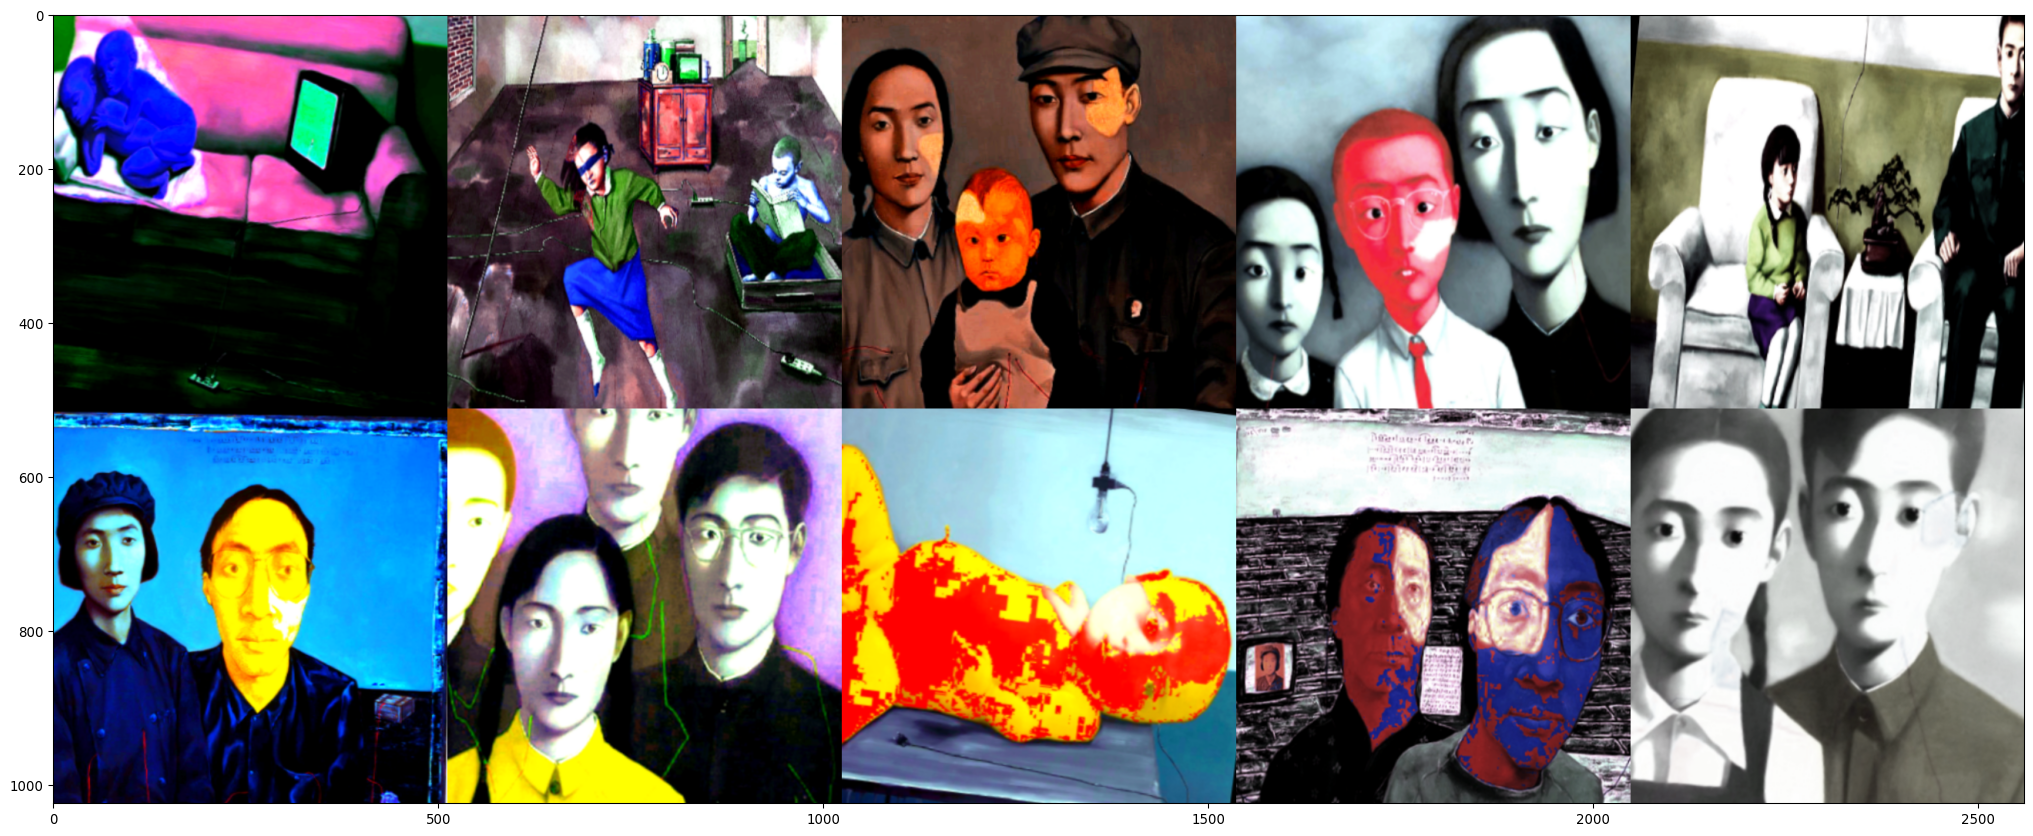

In [5]:
import imgaug as ia
images_aug = seq(images=images)
ia.imshow(ia.draw_grid(images_aug, cols=5))

In [15]:
import csv

img_dir_new = 'data/zhang_xiaogang/train'
os.makedirs(img_dir_new, exist_ok=True)
cvs_filename = os.path.join(img_dir_new, "metadata.csv")
n_folds = 10

with open(cvs_filename, 'w') as csvfile:
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)    
    # writing the fields
    csvwriter.writerow(['file_name', 'text'])
    
    for fold_id in range(n_folds):
        images_aug = seq(images=images)
        for img_id, img_aug in enumerate(images_aug):
            img_name = img_names[img_id]
            if img_name[-3:] == "jpg":
                img_basename, ext = img_name[:-4], "jpg"
            else: # jpeg
                img_basename, ext = img_name[:-5], "jpeg"
            img_basename_new = f"{img_basename}_{fold_id}.{ext}"
            csvwriter.writerow([img_basename_new, captions[img_id]])
            
            img_path_new = os.path.join(img_dir_new, img_basename_new)
            cv2.imwrite(img_path_new, img_aug[:,:,::-1])